In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [2]:
df = pd.read_csv("more_books.csv",index_col=0)

In [3]:
li = sum([len(df['text'][i]) for i in range(0,len(df)) if list(df['author'])[i] == 'austen'])
def author_word_counts():
    counts = []
    for author in df['author'].unique():
        x = sum([len(df['text'][i]) for i in range(0,len(df)) if list(df['author'])[i] == author])/1000000
        counts.append(x)
    return counts
author_word_counts()

[3.408002,
 1.159766,
 10.816123,
 1.477243,
 1.541803,
 1.154954,
 0.246492,
 5.270853,
 0.657671,
 0.268195,
 3.683216,
 2.197598,
 4.411002,
 6.887567,
 3.465672,
 0.544641]

([<matplotlib.axis.XTick at 0x10bc55cc0>,
 <a list of 16 Text xticklabel objects>)

/Users/lukeborsare/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


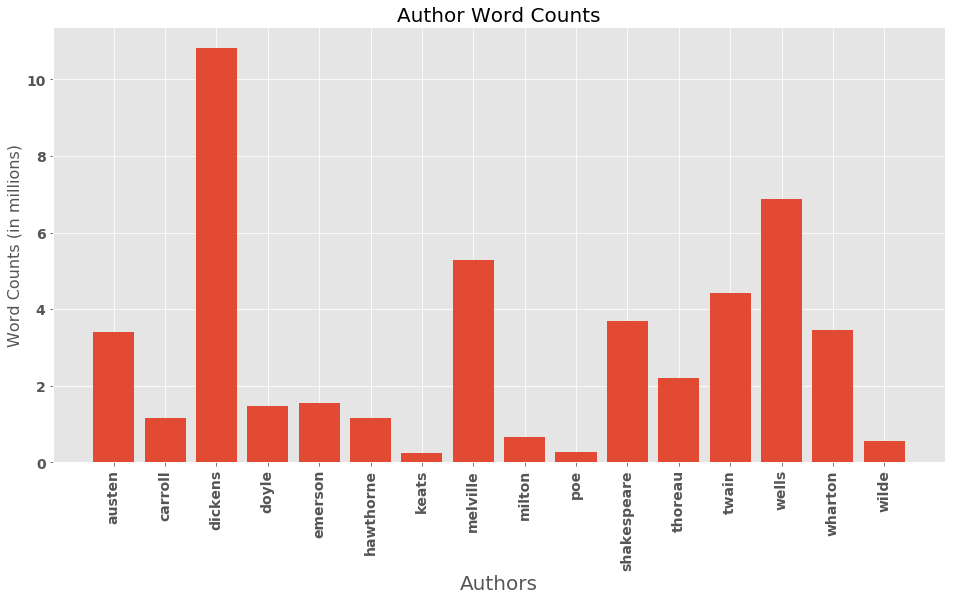

In [203]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,8))
plot = fig.add_subplot(111)
plot.tick_params(axis='both', which='major', labelsize=14)
plt.bar(np.arange(16),author_word_counts())
plt.title("Author Word Counts",fontdict={'family' : 'normal','weight':'normal','size':20})
plt.ylabel("Word Counts (in millions)",fontdict={'family' : 'normal','weight':'normal','size':16})
plt.xlabel("Authors",fontdict={'family' : 'normal','weight':'normal','size':20})
plt.xticks(np.arange(16), df['author'].unique(),rotation='vertical')

In [148]:
#Vectorize and transform data

In [4]:
Bartleby = CountVectorizer()

In [5]:
X_train_counts= Bartleby.fit_transform(df['text'])

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

In [7]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)

In [8]:
X_train_tf = tf_transformer.transform(X_train_counts)

In [9]:
#Split data into testing and training sets

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train_tf,df['author'],train_size=.5,random_state=6,stratify=df['author'])

/Users/lukeborsare/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
X_train

<119x134098 sparse matrix of type '<class 'numpy.float64'>'
	with 483108 stored elements in Compressed Sparse Row format>

In [12]:
#First model I'm trying basic SVM without tuning as baseline

In [13]:
from sklearn.svm import SVC

In [14]:
Homer = SVC(probability=True)

In [15]:
Homer.fit(X_train,y_train)

/Users/lukeborsare/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [16]:
Homer.score(X_test,y_test)

0.15833333333333333

In [17]:
#very low score, moving on to SGD

In [18]:
#baseline SGD

In [19]:
from sklearn.linear_model import SGDClassifier

In [20]:
Dante = SGDClassifier()

In [21]:
Dante.fit(X_train,y_train)

/Users/lukeborsare/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
Dante.score(X_test,y_test)

0.7916666666666666

In [23]:
from sklearn.model_selection import cross_validate

In [24]:
dante_cv_score = cross_validate(Dante,X_train_tf,y=df['author'],cv=5)

/Users/lukeborsare/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [25]:
dante_cv_score['test_score'].mean()

0.8644001753463728

In [34]:
Tolstoy = SGDClassifier(loss='squared_loss',learning_rate="adaptive",eta0=.41,l1_ratio=0,
                         max_iter=250,alpha=0.0001,penalty='l2')

In [36]:
Tolstoy.fit(X_train,y_train)

/Users/lukeborsare/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.41, fit_intercept=True,
       l1_ratio=0, learning_rate='adaptive', loss='squared_loss',
       max_iter=250, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False)

In [37]:
Tolstoy.score(X_test,y_test)

0.8916666666666667

In [38]:
#SGD SVM is a massive improvement even without tuning, sticking with this model for now

In [39]:
cv_score = cross_validate(Tolstoy,X_train_tf,y=df['author'],cv=5)

/Users/lukeborsare/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [40]:
cv_score['test_score'].mean()

0.9147125247149257

In [41]:
#classification report to identify class accuracy and recall

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [43]:
print(classification_report(y_test, Tolstoy.predict(X_test)))

              precision    recall  f1-score   support

      austen       1.00      1.00      1.00         3
     carroll       1.00      1.00      1.00         5
     dickens       0.75      0.90      0.82        10
       doyle       1.00      1.00      1.00        11
     emerson       1.00      1.00      1.00         6
   hawthorne       1.00      1.00      1.00         5
       keats       0.86      0.67      0.75         9
    melville       1.00      1.00      1.00         5
      milton       0.83      0.83      0.83         6
         poe       1.00      0.67      0.80         9
 shakespeare       0.90      1.00      0.95        19
     thoreau       0.80      1.00      0.89         4
       twain       1.00      0.71      0.83         7
       wells       0.60      1.00      0.75         6
     wharton       0.80      0.67      0.73         6
       wilde       1.00      0.89      0.94         9

   micro avg       0.89      0.89      0.89       120
   macro avg       0.91   

In [44]:
print(list(df['author'].unique()))

['austen', 'carroll', 'dickens', 'doyle', 'emerson', 'hawthorne', 'keats', 'melville', 'milton', 'poe', 'shakespeare', 'thoreau', 'twain', 'wells', 'wharton', 'wilde']


In [57]:
testtext = """
here's a great example of a well written readme for a data science project 
we're voting on class names at feelings today! i believe the contenders are Sklearners, Nan's Values, and Pandamonium.
We are going to do a code exchange at 930 instead of code challenge. We'll still meet in nightingale just sit with your partner.Get ready to vote!
 we are off the floor until the end of the day. slack us with questions if you have them!
"""

In [58]:
def classify_text(string):
    st = [string]
    tf_transformer.transform(Bartleby.transform(st))
    return Tolstoy.predict(tf_transformer.transform(Bartleby.transform(st)))

In [59]:
classify_text(testtext)

array(['thoreau'], dtype='<U11')

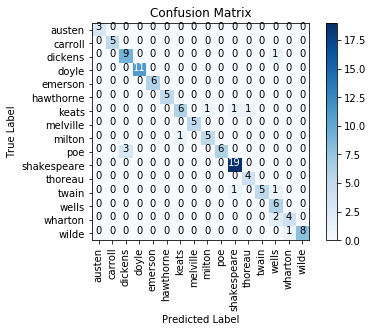

In [49]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = list(df['author'].unique())
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names, rotation='vertical')
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

show_cf(y_test, Tolstoy.predict(X_test))

In [50]:
#Plot AUC
def plotauc():
    X = X_train_tf
    y = df['author']

    # Binarize the output
    y = label_binarize(y, classes=['austen', 'dickens', 'doyle', 'emerson', 'hawthorne', 'keats',
           'melville', 'milton', 'poe', 'shakespeare', 'twain', 'wilde'])
    n_classes = y.shape[1]

    X_train,X_test,y_train,y_test = train_test_split(X_train_tf,y,train_size=.8,stratify=y,random_state=6)

    classifier = OneVsRestClassifier(SGDClassifier(loss='squared_loss',learning_rate="adaptive",eta0=.41,l1_ratio=0,max_iter=250,alpha=0.0001,penalty='l2',class_weight="balanced",average=True))
    y_score = classifier.fit(X_train, y_train).predict(X_test)
    classes=['austen', 'dickens', 'doyle', 'emerson', 'hawthorne', 'keats',
           'melville', 'milton', 'poe', 'shakespeare', 'twain', 'wilde']
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['navy', 'blue', 'deepskyblue', 'green', 'limegreen', 'yellow', 'orange', 'red', 'deeppink', 'pink', 'm', 'purple'])
    plt.figure(figsize=(10,8))
    for i, color,cl in zip(range(n_classes), colors,classes):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(cl, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()
    return classifier

In [ ]:
plotauc()